# 1. Introduktion
Vi vil ved hjælp af diverse pakker udviklet til python kigge på vores datasæt, hvor vi vil arbejde med demografisk filtrering, se på fordele og ulemper med demografisk filtrering dernæst vil vi arbejde med indhold baseret filtrering.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import nltk
from nltk.corpus import stopwords
import math

In [118]:
df_credits = pd.read_csv("data/tmdb_5000_credits.csv")
df_movies = pd.read_csv("data/tmdb_5000_movies.csv")

Efter at vi har læst vores data filer, vil vi gerne se nærmerer på dem, for at skabe en generel forståelse for datasættets indhold.

In [119]:
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [120]:
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


Det ses at begge datasæt indeholder en variabel kaldet "id" og "movie_id". Dette er en reference variabel der er ens for begge datasæt, det betyder, at en vilkårlig film med eksempelvis titel "Avatar" har "id" = 19995 og det samme er gældende for "movie_id" med samme titel, har også værdien 19995.

Vi vil gerne samle vores data, så vi tilføjer "crew" og "cast" til vores film datasæt og dette kan vi gøre på id'et, da de er ens for begge datasæt. Inden vi gør det, fjerner vi variablen "title" fra vores "credits" datasæt, da titlen er redundant og dermed allerede eksistere i vores film datasæt.

In [121]:
df_credits.drop('title', axis=1, inplace=True)
df_credits.columns = ['id', 'cast', 'crew']
main_df = df_movies.merge(df_credits, on="id")
main_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [122]:
main_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [123]:
main_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [124]:
main_df.shape

(4803, 22)

In [125]:
main_df.size

105666

In [126]:
main_df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

# Top 10 film

### Top 10 film baseret på den gennemsnitlige bedømmelse
Nu når alt data er samlet ét datasæt, er vi nu interesseret, at give nogle film anbefalinger ud fra det data vi er givet.
Dette kan lade sig gøre ved at se på variablen vote_average.

In [127]:
main_df[["title", "release_date", "vote_average", "vote_count"]].sort_values("vote_average", ascending=False).head(10)

,title,release_date,vote_average,vote_count
3519,Stiff Upper Lips,1998-06-12,10.0,1
4247,Me You and Five Bucks,2015-07-07,10.0,2
4045,"Dancer, Texas Pop. 81",1998-05-01,10.0,1
4662,Little Big Top,2006-01-01,10.0,1
3992,Sardaarji,2015-06-26,9.5,2
2386,One Man's Hero,1999-08-02,9.3,2
2970,There Goes My Baby,1994-09-02,8.5,2
1881,The Shawshank Redemption,1994-09-23,8.5,8205
2796,The Prisoner of Zenda,1937-09-03,8.4,11
3337,The Godfather,1972-03-14,8.4,5893


Det ses på tabellen ovenfor de 10 bedst bedømte film.<br>
Dette er ikke særlig given, da vi kan se nogle af de bedst rated film kun har 1 til 2 stemmer.

### Top 10 film baseret på det vægtede gennemsnit

Derfor vil vi lave en ny rating variabel der giver filmene en ny rating der også betragter antal stemmer den enkelte film har fået. Dette kan gøres ved hjælp af noget kaldt "Weighted Rating", der kan skrives som:<br>
Weighted Rating (WR)=(v/(v+m))R+(m/(v+m))C<br>
hvor:<br>
R = gennemsnits rating for filmen = "vote_average".<br>
v = antallet af stemmer for filmen = "vote_count".<br>
m = minimum antal stemmer krævet, for at være en "gyldig" film.<br>
C = gennemsnits rating for alle film.<br>

In [128]:
m = main_df['vote_count'].quantile(0.9) #minimum votes 90% percentil
C = main_df["vote_average"].mean() #rating mean

wr_movies = main_df.copy().loc[main_df['vote_count'] >= m] #removes movies, that does not have the minimum required votes
wr_movies["WR"] = (main_df["vote_count"]/(main_df["vote_count"] + m)) * main_df["vote_average"] + (m/(main_df["vote_count"] + m)) * C

##### Det nye resultat
Der sorteres nu på de 10 bedste film baseret på vores nye variabel kaldet "WR" og det ses nu, at de film anbefalet baseret på WR er langt fra de 10 film vi fik anbefalet tidligere, dette skyldes at der vægtes på antallet af stemmer en film har modtaget.

In [129]:
wr_movies[['title', "release_date", 'vote_average', 'vote_count', 'WR']].sort_values("WR", ascending=False).head(10)

,title,release_date,vote_average,vote_count,WR
1881,The Shawshank Redemption,1994-09-23,8.5,8205,8.059258
662,Fight Club,1999-10-15,8.3,9413,7.939256
65,The Dark Knight,2008-07-16,8.2,12002,7.920020
3232,Pulp Fiction,1994-10-08,8.3,8428,7.904645
96,Inception,2010-07-14,8.1,13752,7.863239
3337,The Godfather,1972-03-14,8.4,5893,7.851236
95,Interstellar,2014-11-05,8.1,10867,7.809479
809,Forrest Gump,1994-07-06,8.2,7927,7.803188
329,The Lord of the Rings: The Return of the King,2003-12-01,8.1,8064,7.727243
1990,The Empire Strikes Back,1980-05-17,8.2,5879,7.697884


# Populære film

Vi kan nu give en komfortabel anbefaling af film baseret på deres bedømmelse, men nogle af de film er af ældre dato, hvilket leder os frem til spørgsmåle - hvad der er populært lige nu og her?

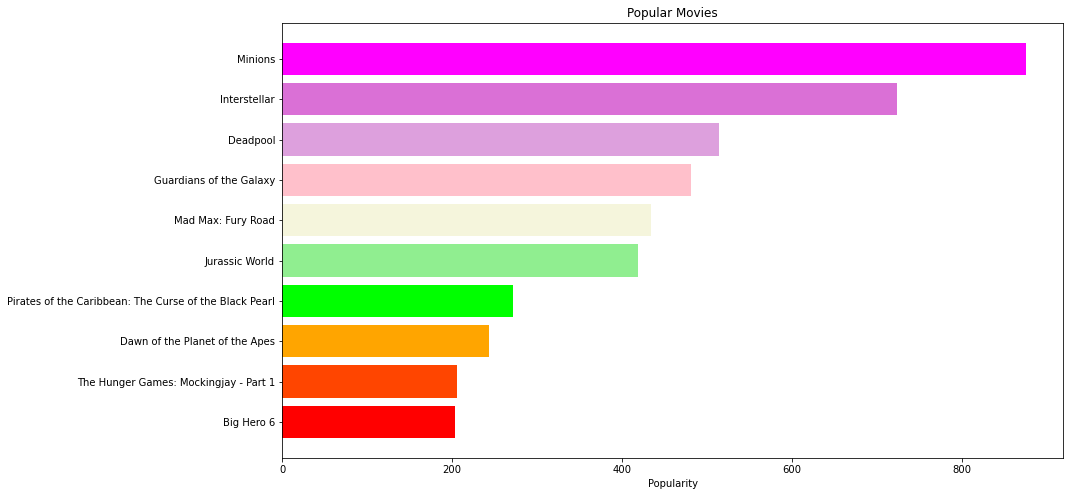

In [130]:
popular_movies = main_df.sort_values("popularity", ascending=False)

plt.figure(figsize=(14,8))

plt.barh(popular_movies['title'].head(10),popular_movies['popularity'].head(10), 
         align='center', color=('magenta', 'orchid', 'plum', 'pink', 'beige', 
                                'lightgreen', 'lime', 'orange', 'orangered', 'red'))
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")
plt.show()

### Data cleaning
Selvom vi har nogle løsninger i form af anbefalinger er løsningerne meget overfaldiske og generelle, da de ikke tager højde for den enkelte brugers preferencer. <br>
Dette vil vi tage højde for nu, ved at indtaste eksempelvis sin yndlingsfilm og ud fra den film finde film der minder om den indtastede film.<br>
Da mange af variablerne indeholder tekst værdier, er det nødvendigt at lave tekst om til noget vi kan regne på eksempelvis med tal værdier. Dette kan lade sig gøre ved hjælp af TD-IDF. <br>
Der eksisterer dog nogle variabler i datasættet der har værdier vi gerne vil rense, for unødvendige værdier og omskrive til nogle håndgribelige værdier, så vi kan udfører vores tekst analyse.

In [131]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [132]:
# Get all the "names" from genre, cast, crew, keywords, productions_companies and spoken_languages.
# If there are no "names" return an empty list
def get_list(x):
    return [i['name'] for i in x] if isinstance(x, list) else []

In [133]:
cleaned_df = main_df

features = ['cast', 'crew', 'keywords', 'genres', 'production_companies', 'spoken_languages']
for feature in features:
    cleaned_df[feature] = cleaned_df[feature].apply(literal_eval)

# Define new director, cast, genres and keywords features that are in a suitable form.
cleaned_df['director'] = cleaned_df['crew'].apply(get_director)

for feature in features:
    cleaned_df[feature] = cleaned_df[feature].apply(get_list)
    
    



#### Sådan ser de nye variabler ud efter noget rensning

In [134]:
cleaned_df[features].head()

,cast,crew,keywords,genres,production_companies,spoken_languages
0,"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Stephen E. Rivkin, Rick Carter, Christopher B...","[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...","[English, Español]"
1,"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Dariusz Wolski, Gore Verbinski, Jerry Bruckhe...","[ocean, drug abuse, exotic island, east india ...","[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",[English]
2,"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[Thomas Newman, Sam Mendes, Anna Pinnock, John...","[spy, based on novel, secret agent, sequel, mi...","[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]","[Français, English, Español, Italiano, Deutsch]"
3,"[Christian Bale, Michael Caine, Gary Oldman, A...","[Hans Zimmer, Charles Roven, Christopher Nolan...","[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",[English]
4,"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[Andrew Stanton, Andrew Stanton, John Lasseter...","[based on novel, mars, medallion, space travel...","[Action, Adventure, Science Fiction]",[Walt Disney Pictures],[English]


# TF-IDF og Content Based Filtering
Det er nu tid til at påbegynde den del, der anbefaler eksempelvis 10 film baseret på sin yndlingsfilm eller en hvilken som helst anden given film.

In [135]:
# It is required to install stopwords, before running this code. This is done by:
# >conda install -c anaconda nltk
# >python
# >>>import nltk
# >>>nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','', "he's","who's", "it's", 'hes', 'shes', 'whos', '--', '–')
print(stop_words)

{"don't", 'his', 's', 'a', 'them', "that'll", "shouldn't", 'above', "you're", 'is', 'against', "doesn't", '–', 'our', 'here', 'very', "shan't", ';', 'your', 'most', 'off', "hadn't", "aren't", 'doesn', 'yours', "you'd", ',', ':', 'more', 'be', 'whom', 'through', 'when', 'am', "mustn't", 'again', "needn't", 'down', 'because', 'you', 'my', 've', 'between', 'while', 'was', 'not', "it's", 'other', 'will', 'hers', 'ma', 'he', 'mustn', 'h', 'having', 'those', 'both', '+', 'after', 'same', 'needn', '?', 'have', 'who', "'", 'each', "wouldn't", 'being', 'm', 'and', 'had', "won't", 'wasn', 'it', 'how', 'him', 'these', 'into', 're', "weren't", 'where', 'any', 'll', 'their', 'don', 'on', 'own', 'hasn', 'himself', 'haven', 'wouldn', 'as', "should've", 'if', '!', 'what', 'y', 'no', 'didn', 'does', 'then', 'than', "couldn't", 'about', 'shouldn', 'ourselves', '-', 'yourself', '#', 'mightn', 'further', 'but', 't', 'with', ')', 'at', "she's", "hasn't", 'do', 'just', 'under', 'all', '$', "didn't", 'such',

In [136]:
#Replace NaN with an empty string
cleaned_df['overview'] = cleaned_df['overview'].fillna('') # Or drop NA?

In [137]:
def overview_cleaning(x):
    x = x.lower().strip('[]').replace('"','').replace('?','').replace('.','').replace(',','').replace('(','').replace(')','').replace("'",'').replace('"','').replace(':','').split()
    return [w for w in x if w not in stop_words]

In [138]:
cleaned_df['overview_cleaned'] = cleaned_df['overview'].apply(lambda x: overview_cleaning(x))

In [139]:
sentence = cleaned_df['overview_cleaned']
unique_words = []
for words in sentence:
    unique_words.extend(words)
#unique_words = pd.Series(unique_words)
unique_words = ([w for w in unique_words])
unique_words = list(set(unique_words))
print(len(unique_words))

24082


In [140]:
def tf_calculator(x):
    tf_dict = dict.fromkeys(x, 0)

    for w in x:
        tf_dict[w] += 1
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / len(x)
    return tf_dict

In [141]:
tf = cleaned_df['overview_cleaned'].apply(lambda x: tf_calculator(x))

In [142]:
def idf_calculator():
    idf_dict = dict.fromkeys(unique_words, 0)
    n = len(cleaned_df)
    for word in unique_words:
        for movie in cleaned_df['overview_cleaned']:
            if word in movie:
                idf_dict[word] += 1
            
    for word in idf_dict:            
        idf_dict[word] = math.log10(n/idf_dict[word])
    return idf_dict

In [143]:
idf = idf_calculator()

In [144]:
print(idf)

{'mill': 3.2043913319193, 'died': 2.4773926039830374, 'crafts': 3.681512586638962, 'bev': 3.681512586638962, 'pandoras': 3.079452595311, 'inhabits': 3.380482590974981, 'robbing': 2.9825425823029432, 'birdees': 3.681512586638962, 'christine': 3.079452595311, 'cheri': 3.681512586638962, 'susumu': 3.681512586638962, 'flashback': 3.681512586638962, 'devi': 3.681512586638962, 'perpetual': 3.681512586638962, 'paddington': 3.681512586638962, 'endless': 2.7784225996470187, 'sex-crazed': 3.380482590974981, 'dovers': 3.681512586638962, 'scrapbooks': 3.681512586638962, 'censored': 3.681512586638962, 'wise-beyond-her-years': 3.681512586638962, 'musters': 3.681512586638962, 'rough-hewn': 3.681512586638962, 'screenwriter': 2.9825425823029432, 'frank': 2.0480441310593758, 'comrades': 3.681512586638962, 'leather-clad': 3.380482590974981, 'dory': 3.681512586638962, 'peculiar': 3.079452595311, 'holders': 3.681512586638962, 'beat-beat': 3.681512586638962, 'fay': 3.681512586638962, 'brainwashed': 3.380482

In [68]:
#document_dict = dict.fromkeys(document, 0)
#for word in words:
#    document_dict[word] += 1
    
#print(document_dict)

In [69]:
# Kode jeg har arbejdet med tidligere der måske (højstsandsyneligt ikke) kan anvendes.

#def word_counter(x):
#    temp_dict = dict.fromkeys(filtered_words, 0)

#    for w in x:
#        temp_dict[w] += 1
#    return temp_dict

#filtered_dict = dict.fromkeys(filtered_words, 0)
#movie_words_dict = []
#for words in cleaned_df['overview_cleaned']:
#    movie_words_dict.append(word_counter(words))

#print(movie_words_dict[0])



#words = cleaned_df['overview'].str.strip('[]').str.replace('"','').str.replace('?','').str.replace('.','').str.replace(',','').str.replace('(','').str.replace(')','').str.replace("'",'').str.replace('"','').str.split()
#document = []
# for word in words:
#     document.extend(word)
#
# document = pd.Series(document)
# document = ([w for w in document if w not in stop_words and w not in document])
# document = list(set(document))
#
# bow_dict = dict.fromkeys(document, 0)

# bag_of_words_list = []
# bag_of_words_list.append(_eval_bag_of_words(document))
#
# print(bag_of_words_list[0])
#
#
# def compute_tf(movie_bow, bow):
#     tf_dict = {}
#     for word, count in movie_bow.items():
#         tf_dict[word] = count / float(len(bow))
#     return tf_dict
#
#
# print(compute_tf(bag_of_words_list[0], words[0]))


### Eksekvering af TF-IDF ved anvendelse af sklearn pakken
Det ses tydeligt at performance er langt bedre, da eksekveringstiden er få sekunder.

In [52]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
#tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
#tfidf_matrix = tfidf.fit_transform(cleaned_df['overview'])

#Output the shape of tfidf_matrix
#tfidf_matrix.shape

#print(tfidf_matrix)

  (0, 3545)	0.27493285363270825
  (0, 795)	0.2084074203878777
  (0, 14754)	0.26556705630591243
  (0, 13355)	0.2537072195025191
  (0, 7414)	0.2153609580612842
  (0, 19054)	0.23864791282019557
  (0, 12269)	0.1778447209530258
  (0, 19671)	0.24152597853522884
  (0, 13644)	0.29248619979162926
  (0, 12411)	0.27155366980600426
  (0, 5519)	0.27863433071832444
  (0, 11667)	0.2580267910376776
  (0, 13680)	0.3411386462681145
  (0, 3232)	0.19886014555883547
  (0, 225)	0.3055534742040413
  (1, 14969)	0.2764509091386784
  (1, 18376)	0.37466189442120984
  (1, 6188)	0.2743698871995736
  (1, 19418)	0.3060153616124342
  (1, 6016)	0.1966138874334538
  (1, 6069)	0.2948248727159851
  (1, 8674)	0.2809447973706985
  (1, 11025)	0.12158034118460531
  (1, 3843)	0.19195626583733216
  (1, 4854)	0.19967394354414503
  :	:
  (4802, 5841)	0.34247058916908363
  (4802, 4576)	0.15002600185636672
  (4802, 10126)	0.15121328276821538
  (4802, 16409)	0.17123529458454181
  (4802, 4816)	0.14223771161926407
  (4802, 1311)	0.16